In [135]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from pymongo import MongoClient
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from seaborn import plt
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import PolynomialFeatures

# Classification to optimize weights of the features

Train logistic regression model based on sentences in abstracts (1) and sentences in examples (0)
Retain the optimal parameters to calculate sentence scores. Make sure that the classses aren't contiguous, shuffle the data!  

Question: what would the score of a sentence look like exactly? The probas of the model? Is Logisitc Regression the only option?

In [32]:
data = joblib.load('data_classification')

In [33]:
data.head()

,sentence,length,named_entities,k_important,position,upper,nouns,verbs,adjectives,category
0,The paper will argue for the existence of null...,63,4,28,0.0,14,13,9,6,1
1,I will present a set of paradoxical cases in w...,32,1,13,20.0,4,8,4,3,1
2,I will suggest that the domain of locality rel...,29,3,15,40.0,4,4,5,4,1
3,"Specifically, it will be proposed that a resum...",31,3,12,60.0,13,3,6,1,1
4,The CCRC will explain why resumptive dependenc...,34,7,15,80.0,9,4,5,3,1


## Normalization

Purpose: 
* deal with outliers
* If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.
* Normalization is the process of scaling individual samples to have unit norm.

# Classification

## Logistic Regression

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [48]:
y = data.category
X = data.drop(['category', 'sentence'], axis = 1)

In [49]:
print(X.shape)
print(y.shape)

(37361, 8)
(37361,)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
mod = make_pipeline(Normalizer(), LogisticRegression(n_jobs=-1))
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))
acs = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))

In [73]:
print(acs)
print(cr)

0.839096456482
             precision    recall  f1-score   support

          0       0.87      0.80      0.84      4785
          1       0.81      0.88      0.84      4556

avg / total       0.84      0.84      0.84      9341



Precision: of all the ones that I classified as positive, how many really were?  
Recall: of all the ones that were positive in reality, how many did I find?  

Useless sentences are not identified as well as informative sentences; useless sentences are more likely to be really useless than informative sentences.  
Bref: the model does well at identifying informative sentences, it does slightly worse on identifying uselss sentences.

In [75]:
mod.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('normalizer', Normalizer(copy=True, norm='l2')), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])>

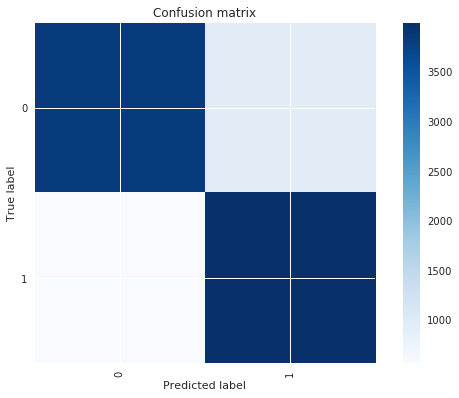

In [74]:
plot_confusion_matrix(cm, list(np.unique(y_train)))

### Gridsearch

In [89]:
parameters = {'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag']}
X_train_normal = Normalizer().fit_transform(X_train)
X_test_normal = Normalizer().fit_transform(X_test)
clf = GridSearchCV(LogisticRegression(), param_grid=parameters, n_jobs=-1)
clf.fit(X_train_normal, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [90]:
print("Best parameters set found on development set: \n")
print(clf.best_params_)

Best parameters set found on development set: 

{'solver': 'newton-cg'}


In [91]:
parameters = {'penalty':['l2', 'l1']}
X_train_normal = Normalizer().fit_transform(X_train)
X_test_normal = Normalizer().fit_transform(X_test)
clf = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid=parameters, n_jobs=-1)
clf.fit(X_train_normal, y_train)
print("Best parameters set found on development set: \n")
print(clf.best_params_)

Best parameters set found on development set: 

{'penalty': 'l1'}


In [85]:
mod = make_pipeline(Normalizer(), LogisticRegression(solver='newton-cg', n_jobs=-1))
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))
acs = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))

In [86]:
print(acs)
print(cr)

0.838882346644
             precision    recall  f1-score   support

          0       0.87      0.80      0.84      4785
          1       0.81      0.88      0.84      4556

avg / total       0.84      0.84      0.84      9341



This is the same result as with the liblinear solver.

In [109]:
mod = LogisticRegression(solver='liblinear', penalty='l1', n_jobs=-1)
mod.fit(X_train_normal, y_train)
y_pred = mod.predict(X_test_normal)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))
acs = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))

In [110]:
mod.coef_

array([[-12.75552024,  10.7071918 ,  32.97250852,  -1.06255969,
         -5.54427811,   0.        ,   3.33105565,   2.19126917]])

In [111]:
print(acs)
print(cr)

0.841665774542
             precision    recall  f1-score   support

          0       0.87      0.81      0.84      4785
          1       0.81      0.88      0.84      4556

avg / total       0.84      0.84      0.84      9341



We always get the same results, so let's just go for the default.

### Cross-Validation

In [94]:
cv = ShuffleSplit(n_splits=5, test_size=0.3)
cross_val_score(mod, X_train_normal, y_train, cv=cv)

array([ 0.83940043,  0.84380205,  0.84249346,  0.84594337,  0.847133  ])

### Polynomial

In [137]:
pipeline = Pipeline([('norm', Normalizer()), ('poly', PolynomialFeatures()), ('log', LogisticRegression())])
parameters = {'poly__degree': list(range(7)), 'log__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag']}

In [138]:
grid = GridSearchCV(pipeline, param_grid=parameters, n_jobs=-1)
grid.fit(X_train, y_train)

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('norm', Normalizer(copy=True, norm='l2')), ('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('log', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'poly__degree': [0, 1, 2, 3, 4, 5, 6], 'log__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [139]:
print("Best parameters set found on development set: \n")
print(grid.best_params_)

Best parameters set found on development set: 

{'log__solver': 'newton-cg', 'poly__degree': 6}


In [140]:
print("Best score: %0.3f" % grid.best_score_)
print("Best parameters set:")
best_parameters = grid.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.849
Best parameters set:
	log__solver: 'newton-cg'
	poly__degree: 6


Not much of an improvement. Let's do a cross-val on the best model:

In [141]:
pipeline = Pipeline([('norm', Normalizer()), ('poly', PolynomialFeatures(degree=6)), 
                     ('log', LogisticRegression(solver='newton-cg', n_jobs=-1))])

In [142]:
cv = ShuffleSplit(n_splits=5, test_size=0.3)
cross_val_score(pipeline, X_train, y_train, cv=cv)

array([ 0.85212943,  0.84772781,  0.84308827,  0.84963122,  0.84356412])

In [145]:
log_fin = Pipeline([('norm', Normalizer()), ('poly', PolynomialFeatures(degree=6)), 
                     ('log', LogisticRegression(solver='newton-cg', n_jobs=-1))])
log_fin.fit(X_train, y_train)
y_pred = log_fin.predict(X_test)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))

In [146]:
print(cr)

             precision    recall  f1-score   support

          0       0.87      0.82      0.85      4785
          1       0.82      0.87      0.85      4556

avg / total       0.85      0.85      0.85      9341



These results are slightly better on recall than with the basic model, but the model is way more complex. Is it worth it?

## Random Forests

In [106]:
rf = make_pipeline(Normalizer(), RandomForestClassifier(n_jobs = -1))
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))
acs = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))

In [97]:
print(cr)
print(acs)

             precision    recall  f1-score   support

          0       0.85      0.85      0.85      4785
          1       0.85      0.84      0.84      4556

avg / total       0.85      0.85      0.85      9341

0.848624344289


In [104]:
parameters = {'max_depth': range(5, 20), 'min_samples_split' : range(2, 10, 2)}
clf_rf = GridSearchCV(RandomForestClassifier(n_estimators = 100), parameters, n_jobs = -1)
clf_rf.fit(X_train_normal, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 20), 'min_samples_split': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [105]:
print("Best parameters set found on development set: \n")
print(clf_rf.best_params_)

Best parameters set found on development set: 

{'max_depth': 17, 'min_samples_split': 8}


In [114]:
rf = RandomForestClassifier(max_depth=17, min_samples_split=8, n_estimators=100, n_jobs=-1)
rf.fit(X_train_normal, y_train)
y_pred = rf.predict(X_test_normal)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))
acs = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))

In [112]:
sorted(list(zip(X_train.columns, rf.feature_importances_)), key = lambda x: x[1])

[('named_entities', 0.041450878462891659),
 ('verbs', 0.051165834861816348),
 ('adjectives', 0.072280844601537012),
 ('nouns', 0.074669890591475399),
 ('length', 0.11606623047937072),
 ('position', 0.17180271002872657),
 ('upper', 0.22508163769671885),
 ('k_important', 0.24748197327746357)]

In [115]:
print(cr)
print(acs)

             precision    recall  f1-score   support

          0       0.88      0.84      0.86      4785
          1       0.84      0.88      0.86      4556

avg / total       0.86      0.86      0.86      9341

0.859758055883


Random forests does slightly better than Logistic Regression.

## Bernoulli Naive Bayes

In [117]:
nb = make_pipeline(Normalizer(), BernoulliNB())
nb.fit(X_train, y_train)
y_pred = mod.predict(X_test)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))
acs = metrics.accuracy_score(y_test, y_pred)
cm = metrics.confusion_matrix(y_test, y_pred, labels=list(np.unique(y_train)))

In [118]:
print(cr)
print(acs)

             precision    recall  f1-score   support

          0       0.66      0.96      0.78      4785
          1       0.92      0.49      0.63      4556

avg / total       0.79      0.73      0.71      9341

0.727438175784


This one sucks...

## XGBoost

In [121]:
from xgboost import XGBClassifier

/home/aleksandra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [122]:
xg = make_pipeline(Normalizer(), XGBClassifier())
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))

In [123]:
print(cr)

             precision    recall  f1-score   support

          0       0.88      0.83      0.85      4785
          1       0.83      0.89      0.86      4556

avg / total       0.86      0.86      0.86      9341



In [124]:
parameters = {'max_depth': range(5, 20)}
clf_xg = GridSearchCV(XGBClassifier(subsample=0.5), parameters, n_jobs = -1)
clf_xg.fit(X_train_normal, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.5),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(5, 20)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [125]:
print("Best parameters set found on development set: \n")
print(clf_xg.best_params_)

Best parameters set found on development set: 

{'max_depth': 6}


In [126]:
xg = XGBClassifier(max_depth=6)
xg.fit(X_train_normal, y_train)
y_pred = xg.predict(X_test_normal)
cr = metrics.classification_report(y_test, y_pred, labels=list(np.unique(y_train)))

In [127]:
print(cr)

             precision    recall  f1-score   support

          0       0.88      0.83      0.86      4785
          1       0.83      0.89      0.86      4556

avg / total       0.86      0.86      0.86      9341



In [128]:
sorted(list(zip(X_train.columns, xg.feature_importances_)), key = lambda x: x[1])

[('named_entities', 0.082943641),
 ('adjectives', 0.091311842),
 ('nouns', 0.099680036),
 ('verbs', 0.11149397),
 ('position', 0.11666256),
 ('upper', 0.12576914),
 ('length', 0.17597835),
 ('k_important', 0.19616047)]

In comparison with RF, we get more or less the same results. RF does slightly better though. Same feature importances.

## Conclusion:
We always get more or less the same results. I will just stick to the basic Logistic Regression model with normalization. It's simple, fast, gives me weights and probabilities. It's what I need

# And the winner is...

In [149]:
model = make_pipeline(Normalizer(), LogisticRegression(n_jobs=-1))
fitted = model.fit(X, y)

In [154]:
df_probas = pd.DataFrame(fitted.predict_proba(X))

In [151]:
df_probas.head()

,0,1
0,0.049073,0.950927
1,0.154227,0.845773
2,0.034586,0.965414
3,0.432618,0.567382
4,0.178678,0.821322


In [152]:
joblib.dump(model, 'scorer')


['scorer']

In [156]:
fitted.predict_proba(X)[0]

array([ 0.04907286,  0.95092714])

In [158]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int64